In [1]:
##### -1 -> 1 Image values


#from sklearn.metrics.pairwise import pairwise_distances

from itertools import product
from PIL import Image, ImageOps

import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns
plt = matplotlib.pyplot

%matplotlib inline

sns.set_style('whitegrid')

matplotlib.rcParams.update({'figure.figsize': (10, 6)})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})

%config InlineBackend.figure_format = 'retina'

In [2]:
image_size = (32, 32)
images_per_class = 10000
flip_images = True # Will double the images_per_class

In [3]:
%%time

import random

# the directory immediately under which all the images
# reside.
file_prefix = 'data/'

# The PIL flag for grayscale.
GRAYSCALE_MODE = 'L'

# Will store tuples (id,image_data,is_dog) and then
# will be converted into the DataFrame `images`.
images_list = []

# load data/cat.{i}.jpg and data/dog.{i}.jpg
# for i in a random sampling without replacement of
# an integer population 0...9999 inclusive (all image indices).
for pet_type, index in product(['cat', 'dog'], random.sample(range(10000), images_per_class)):
    file_name = f'{pet_type}.{index}'
    
    # Load and convert to grayscale
    image = Image.open(f'{file_prefix}{file_name}.jpg').convert(mode=GRAYSCALE_MODE)
    
    # Aspect fit the image (shrink the image while maintaining
    # the aspect ratio such that the shorter dimension matches its target value
    # in image_size above. Then center it and crop off the excess to fit in
    # the dimensions of image_size).
    image = ImageOps.fit(image, image_size, method=Image.ANTIALIAS)
    
    # The PIL.ImageData object is essentially a matrix. Linearize it as a numpy array.
    data = (np.array(image.getdata())/255).astype('float32')
    
    # Add the boolean field `is_dog` as a simple representation of our cat/dog dichotomy.
    is_dog = (pet_type == 'dog')
    images_list.append((file_name,data,is_dog))
    
    # Flip the image left/right and add to the data set
    # This is an attempt to help avoiding the overtrainging of our model.
    if flip_images:
        image_f = image.transpose(Image.FLIP_LEFT_RIGHT)
        data_f = (np.array(image_f.getdata())/255).astype('float32')
        images_list.append((file_name+'.f',data_f,is_dog))
        
images = pd.DataFrame(data=images_list,columns=['id','image_data','is_dog'])

CPU times: user 2min 7s, sys: 835 ms, total: 2min 8s
Wall time: 2min 8s


In [4]:
images.head()

,id,image_data,is_dog
0,cat.5386,"[0.172549, 0.188235, 0.172549, 0.168627, 0.184...",False
1,cat.5386.f,"[0.133333, 0.14902, 0.0823529, 0.129412, 0.274...",False
2,cat.360,"[0.552941, 0.580392, 0.592157, 0.6, 0.596078, ...",False
3,cat.360.f,"[0.501961, 0.552941, 0.560784, 0.556863, 0.545...",False
4,cat.8996,"[0.666667, 0.678431, 0.690196, 0.701961, 0.713...",False


In [5]:
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
id            40000 non-null object
image_data    40000 non-null object
is_dog        40000 non-null bool
dtypes: bool(1), object(2)
memory usage: 664.1+ KB


In [6]:
print('images stored as dtype',images.image_data[0].dtype)
print(images_per_class*2,'images,',image_size,'pixels each')
mem = images.memory_usage(deep=True).sum()
print('float64 size:',mem*2/1000000.,'MB')
print('float32 size:',mem/1000000.,'MB')

images stored as dtype float32
20000 images, (32, 32) pixels each
float64 size: 341.35128 MB
float32 size: 170.67564 MB


In [7]:
# [CITE] "04. Dimension Reduction and Images Notebook" by Eric Larson

def plot_gallery(imgs, titles, size, rows=3, cols=6):
    plt.figure(figsize = (1.7 * cols, 2.3 * rows))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    
    for i in range(rows * cols):
        plt.subplot(rows, cols, i+1)
        ax = plt.gca()
        [spine.set_color('black') for _,spine in ax.spines.items()]
        plt.imshow(imgs[i].reshape(size), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks([]); plt.yticks([])
    plt.show()

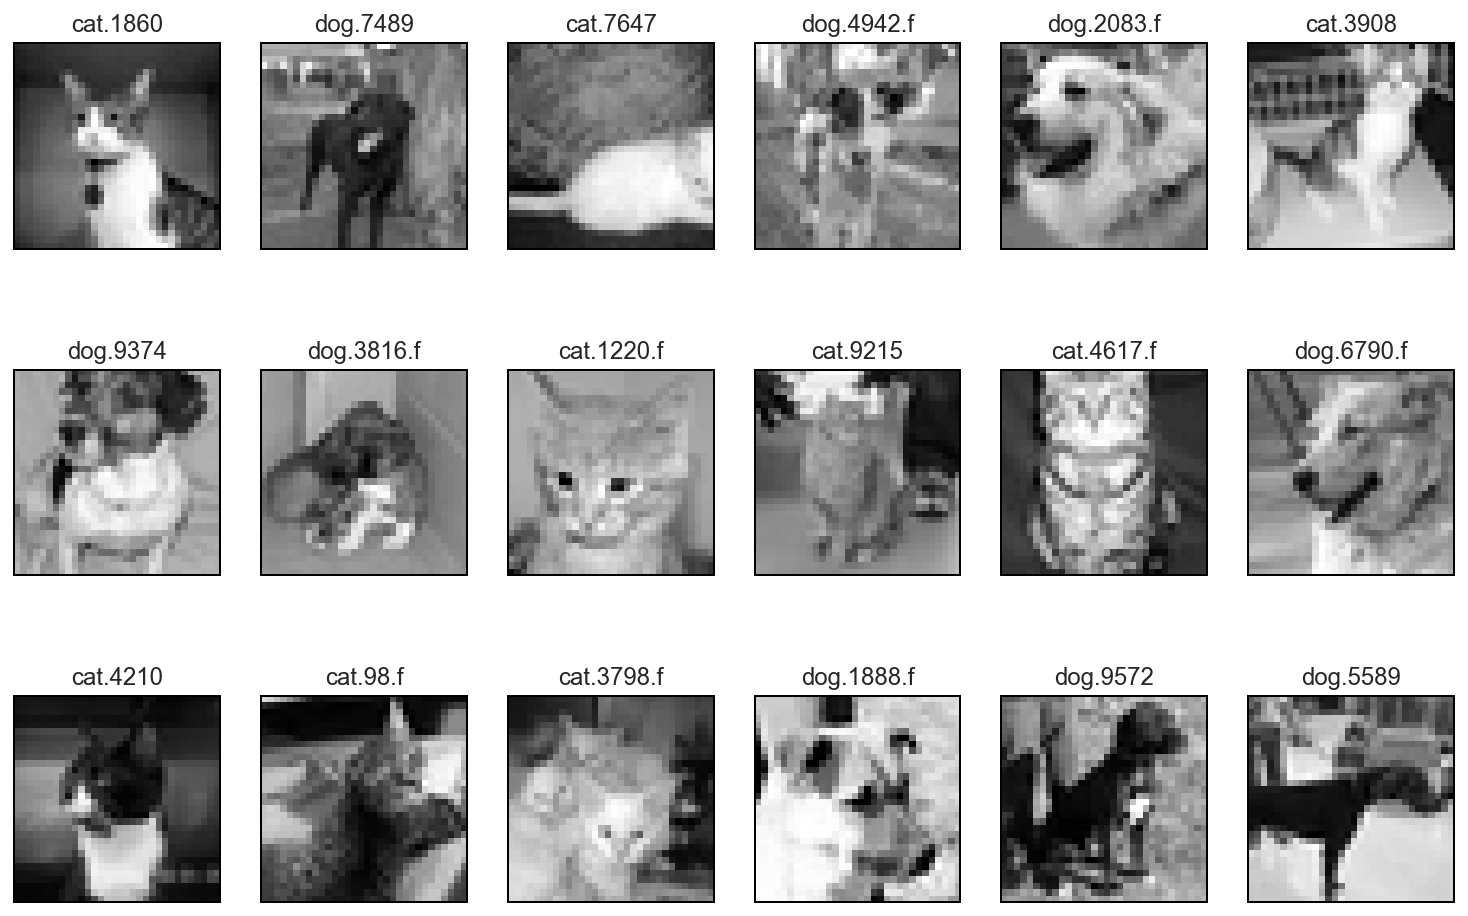

In [8]:
some_images = images.sample(n=18)
plot_gallery(some_images.image_data.iloc, some_images.id.iloc, image_size)

In [9]:
from sklearn.metrics import roc_auc_score
evaluation_function = roc_auc_score

from sklearn.model_selection import StratifiedKFold

n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, random_state=None, shuffle=False)

In [10]:
# we store the networks in this array
# so we can grab their epoch_log_ properties
# wherein we persist the per-epoch accuracy
# so we can make pretty charts.
def cross_validation_step(ModelClass, indices, parameters): 
    train_index, test_index = indices
    X_train = data.iloc[train_index]
    y_train = np.asarray(pd.get_dummies(target.iloc[train_index]))
    X_test = data.iloc[test_index]
    y_test = target.iloc[test_index]
    
    # training
    clf = ModelClass(**parameters)
    clf.fit(X_train, y_train)
    
    # testing
    y_hat_raw = clf.predict(X_test)
    y_hat = ModelClass.one_hot_output(y_hat_raw)
    score = evaluation_function(pd.get_dummies(y_test), y_hat)
    return score,clf

def cross_validation(ModelClass, cv, parameters):
    cv_indices = cv.split(data, target)
    scores = np.empty(n_splits)
    nets = [None]*n_splits
    
    if 'epochs' in parameters:
        total_epochs = n_splits*parameters['epochs']
        print(
            f'Performing {n_splits}-fold Stratified cross validation with {parameters["epochs"]} '
            f'epochs each ({total_epochs} epochs total)'
        )
        if total_epochs > 80:
            print('☕️ you may want to grab a coffee')
        
    # I promise I tried parallelizing this 
    # but Tensorflow didn't like it.
    #
    # (tried threading.Thread and multiprocess.Pool)
    for i,indices in enumerate(cv_indices):
        print(f'Split {i+1} of {n_splits} {"☕️"*(i+1)}')
        scores[i],nets[i] = cross_validation_step(ModelClass, indices, parameters)
        
    return scores,nets

def get_logs_from_nets(nets, parameter_name):
    return [[epoch[parameter_name] for epoch in net.epoch_log_] for net in nets]

# Current CNN

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, BatchNormalization, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import Callback

class ConvolutionalNeuralNet:
    def __init__(
        self,
        input_shape,
        n_filters,
        dense_sizes,
        output_size,
        
        batch_normalize = True,

        layer_activation='relu',
        final_activation='softmax',

        loss='mean_squared_error', 
        optimizer='rmsprop', 
        metrics=['binary_accuracy'],

        batch_size=32,
        epochs=50,
        shuffle=False,
        verbose=2
    ):
        self.input_shape = input_shape
        self.n_filters = n_filters
        self.dense_sizes = dense_sizes
        self.output_size = output_size
        
        self.batch_normalize = batch_normalize
        
        self.layer_activation = layer_activation
        self.final_activation = final_activation
        
        self.loss = loss
        self.optimizer = optimizer
        self.metrics = metrics
        
        self.batch_size = batch_size
        self.epochs = epochs
        self.shuffle = shuffle
        self.verbose = verbose
        
        self._make_model()
    
    def _make_convolution_layers(self):
        self._model.add(
            Reshape(
                (1, self.input_shape[0], self.input_shape[1]), 
                input_shape=(1, self.input_shape[0]*self.input_shape[1])
            )
        )
                       
        for filters in self.n_filters:
                
            # Add a single convolution layer
            self._model.add(
                Conv2D(
                    filters=filters,
                    kernel_size=(3,3),
                    padding='same',
                    activation=self.layer_activation
                )
            )
            # Add batch normalization to the convolution layer
            if self.batch_normalize:
                self._model.add(
                    BatchNormalization(axis=1)
                )
            # Pool the layer
            self._model.add(
                MaxPooling2D(pool_size=(2,2), data_format='channels_first')
            )
        
        self._model.add(Flatten())
                
    def _make_dense_layers(self):
    
        for size in self.dense_sizes:
            self._model.add(
                Dense(size, activation=self.layer_activation)
            )
            if self.batch_normalize:
                self._model.add(
                    BatchNormalization(axis=1)
                )
    
        self._model.add(
            Dense(self.output_size, activation=self.final_activation)
        )
                
    def _make_model(self):
        self._model = Sequential()
        
        self._make_convolution_layers()
        self._make_dense_layers()
        
        self._model.compile(
            loss=self.loss,
            optimizer=self.optimizer,
            metrics=self.metrics
        )
                
    def fit(self, X_raw, y):
        # Using keras Callbacks to hook into end of epoch
        # for per-epoch evaluation statistics collection
        # [CITE] https://github.com/fchollet/keras/issues/2548#issuecomment-215664770
        self.epoch_log_ = []
        net = self
        class AnalyticsCallback(Callback):
            def on_epoch_end(self, epoch, logs={}):
                net.epoch_log_.append(logs)
        
        X = np.matrix(X_raw.tolist())
        X = np.expand_dims(X, axis=1)
        self._model.fit(
            X, y, 
           batch_size=self.batch_size,
           epochs=self.epochs,
           shuffle=self.shuffle,
           verbose=self.verbose,
           callbacks=[AnalyticsCallback()]
        )
                       
    def predict(self, X_raw):
        X = np.matrix(X_raw.tolist())
        X = np.expand_dims(X, axis=1)
        return self._model.predict(X)
    
    @staticmethod
    def one_hot_output(y_hat_raw):
        # predict() outputs floats. We want one-hot in most cases
        y_hat = np.zeros(y_hat_raw.shape, dtype=np.int)
        y_hat[np.arange(y_hat_raw.shape[0]), y_hat_raw.argmax(1)] = 1
        return y_hat

Using TensorFlow backend.


In [34]:
'''
1)  n_filters=[32,64,64,128], #128 64 32
    dense_sizes=[256,256]
    
    
Results:
1) Accuracy (ROC): 0.67 (±0.03)
'''

params = dict(
        input_shape=image_size,
    
        n_filters=[32,64,64,256,256],
        dense_sizes=[128,128],
    
        output_size=2,
        
        loss='binary_crossentropy', 
        optimizer='Nadam', 
        metrics=['binary_accuracy'],
        
        batch_size=32,
        epochs=40,
        shuffle=True,
        verbose=0
)

In [ ]:
%%time

data = images.image_data
target = images.is_dog

scores, nets = cross_validation(ConvolutionalNeuralNet, cv, params)

Performing 10-fold Stratified cross validation with 40 epochs each (400 epochs total)
☕️ you may want to grab a coffee
Split 1 of 10 ☕️
Split 2 of 10 ☕️☕️
Split 3 of 10 ☕️☕️☕️
Split 4 of 10 ☕️☕️☕️☕️
Split 5 of 10 ☕️☕️☕️☕️☕️
Split 6 of 10 ☕️☕️☕️☕️☕️☕️




Accuracy (ROC): 0.67 (±0.03)




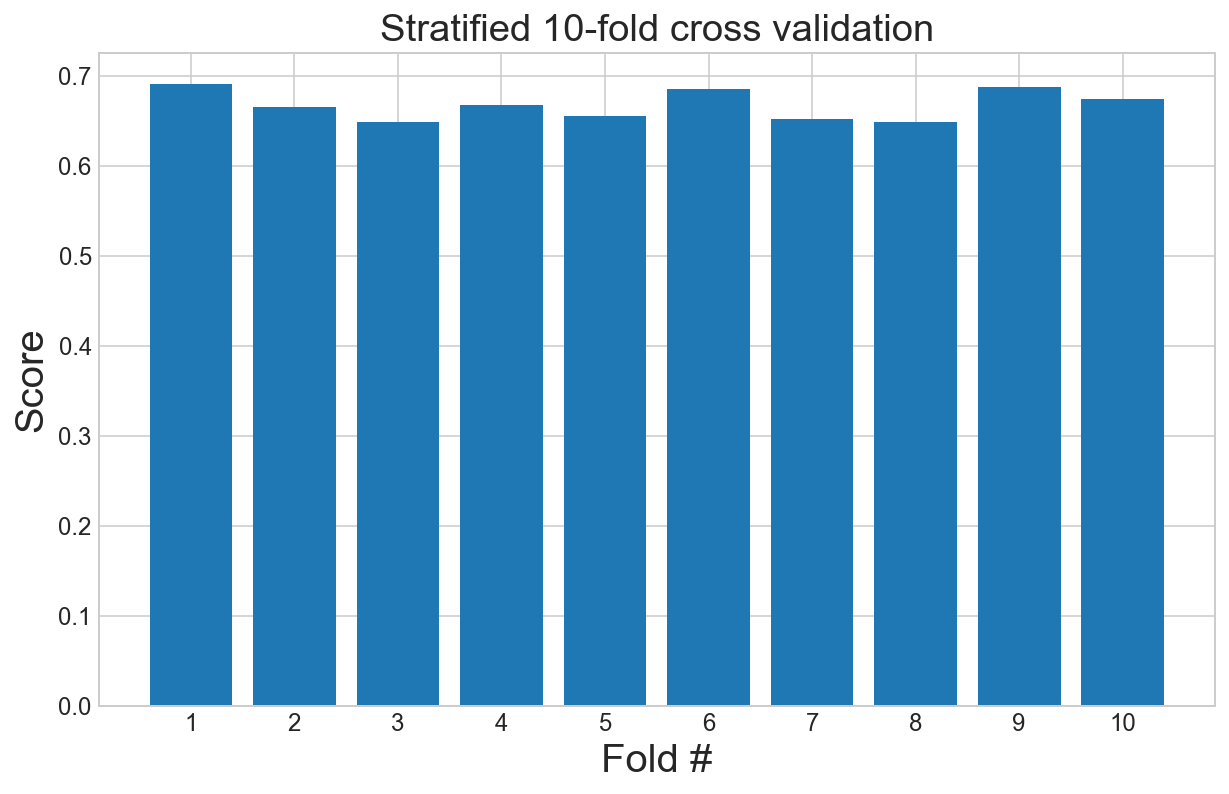

In [14]:
ax = plt.bar(range(len(scores)),scores)
plt.xticks(range(10),range(1,11))
plt.title('Stratified 10-fold cross validation')
plt.xlabel('Fold #')
plt.ylabel('Score')

print(
    '\n','='*50,'Accuracy (ROC): %0.2f (±%0.2f)' % (np.asarray(scores).mean(), np.asarray(scores).std() * 2),
    '='*50,'\n',sep='\n'
)

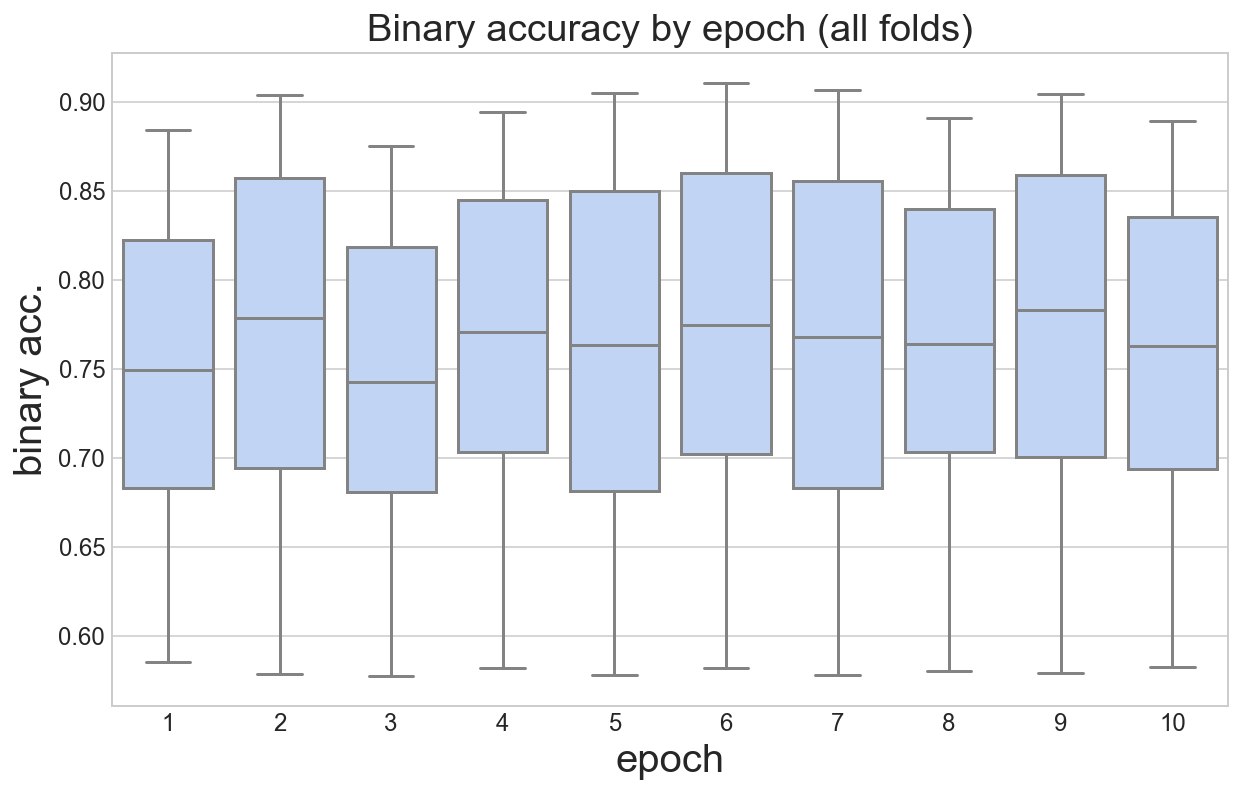

In [15]:
accs = get_logs_from_nets(nets, 'binary_accuracy')
#accs_by_epoch = [[a[i] for a in accs_by_fold] for i in range(len(accs_by_fold))]

ax = sns.boxplot(data=np.array(accs).T, color='#b8d2fc')
ax.set_xticklabels(range(1,11))
plt.xlabel('epoch')
plt.ylabel('binary acc.')
plt.title('Binary accuracy by epoch (all folds)');

# Test

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images.image_data, images.is_dog, test_size=0.1)

In [17]:
y_ohe_train = np.asarray(pd.get_dummies(y_train))
y_ohe_test  = np.asarray(pd.get_dummies(y_test))

In [28]:
params = dict(
        input_shape=image_size,
        n_filters=[32,64,64,256,256], #128 64 32
        dense_sizes=[128,128],
        output_size=2,
    
        batch_normalize = True,
        
        loss='binary_crossentropy', 
        optimizer='rmsprop', 
        metrics=['binary_accuracy'],
        
        batch_size=32,
        epochs=50
    ,
        shuffle=True,
        verbose=1
)

In [29]:
cnn_test = ConvolutionalNeuralNet(**params)
cnn_test._model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_13 (Reshape)         (None, 1, 32, 32)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 1, 32, 32)         9248      
_________________________________________________________________
batch_normalization_75 (Batc (None, 1, 32, 32)         4         
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 1, 16, 16)         0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 1, 16, 64)         9280      
_________________________________________________________________
batch_normalization_76 (Batc (None, 1, 16, 64)         4         
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 1, 8, 32)          0         
__________

In [30]:
%%time

cnn_test.fit(X_train, y_ohe_train)

Epoch 1/50
36000/36000 [==============================] - 28s - loss: 0.6955 - binary_accuracy: 0.5751    
Epoch 2/50
36000/36000 [==============================] - 25s - loss: 0.6449 - binary_accuracy: 0.6316    
Epoch 3/50
36000/36000 [==============================] - 25s - loss: 0.6270 - binary_accuracy: 0.6517    
Epoch 4/50
36000/36000 [==============================] - 25s - loss: 0.6127 - binary_accuracy: 0.6684    
Epoch 5/50
36000/36000 [==============================] - 25s - loss: 0.5973 - binary_accuracy: 0.6826    
Epoch 6/50
36000/36000 [==============================] - 25s - loss: 0.5831 - binary_accuracy: 0.6941    
Epoch 7/50
36000/36000 [==============================] - 25s - loss: 0.5729 - binary_accuracy: 0.7053    
Epoch 8/50
36000/36000 [==============================] - 26s - loss: 0.5590 - binary_accuracy: 0.7154    
Epoch 9/50
36000/36000 [==============================] - 26s - loss: 0.5431 - binary_accuracy: 0.7268    
Epoch 10/50
36000/36000 [============

In [31]:
from sklearn import metrics as mt
yhat = np.argmax(cnn_test.predict(X_test), axis=1)
print("Recall score: " + str(mt.recall_score(y_test,yhat)))

Recall score: 0.901088031652


1) 0.836978131213
2) No change

3) 0.809#145129225

# Test Jake Carlson

In [ ]:
from sklearn.model_selection import train_test_split
JC_X_train, JC_X_test, JC_y_train, JC_y_test = train_test_split(images.image_data, images.is_dog, test_size=0.1)

In [ ]:
JC_y_ohe_train = np.asarray(pd.get_dummies(JC_y_train))
JC_y_ohe_test  = np.asarray(pd.get_dummies(JC_y_test))

In [ ]:
%%time

cnn2 = Sequential()
cnn2.add(Reshape((1,32,32), input_shape=(1,1024)))

num_filters_layers = [32,32,64,128]
for num_filters in num_filters_layers:    
    cnn2.add(
        Conv2D(
            filters=num_filters, 
            kernel_size= (3, 3), 
            padding='same', 
            input_shape=(1,32,32),
            activation = 'relu'
        )
    )
    cnn2.add(
        MaxPooling2D(
            pool_size=(2, 2), 
            data_format="channels_first"
        )
    )

cnn2.add(
    Flatten()
)

cnn2.add(
    Dense(
        64, 
        activation='relu'
    )
)

# Output
cnn2.add(
    Dense(
        2,
        activation='softmax'
    )
)

cnn2.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
JC_X_train = np.matrix(X_train.tolist())
JC_X_train = np.expand_dims(JC_X_train, axis=1)

cnn2.fit(JC_X_train, JC_y_ohe_train,
        batch_size=32, epochs=25, 
        shuffle=True, verbose=1)